# Object Distance Detection

Python Notebook to support theoretical approach to the proposed method of using LIDAR and Yolo to estimate
object distance and to track object distance across several frames (even without detection).

This python notebook contains several steps:

- Loading image sequence
- Applying Edge Detection
- Clustering Objects
- Applying LIDAR horizontal
- Propogating total distance measure to following frames

In [203]:
import os
DATA_FOLDER_PATH = os.path.abspath(os.path.join("data", "v2"))

Hyperparameters left for tuning (bounding box priors)

In [204]:
LIDAR_RANGE = (100, 500)
CLUSTER_DENSITY_RANGE = (500, 5000)
SLICE_RATIO = 0.1

## Utility
Some utility methods to get things going...

In [205]:
import matplotlib.pyplot as plt
def show_image_comparison(img1, img2):
    plt.subplot(121),plt.imshow(img1,cmap = 'gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img2,cmap = 'gray')
    plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
    plt.show()

In [206]:
import os
def load_image_sequence(data_folder_path, seq_length):
    result = []
    counter = 0
    for file in os.listdir(data_folder_path):
        if counter == seq_length:
            break
        result.append(cv2.imread(os.path.join(data_folder_path, file)))
        counter += 1
    return result

## k-means bounding box prior calculations

In [207]:
import cv2
def apply_edge_detection(image, threshold1 = 200, threshold2 = 100):
    return image, cv2.Canny(image, threshold1, threshold2)

In [208]:
from numpy import array
# Method to invalidate null points contained in the Canny's algorithm return value
def invalidate_null_points(edge_image):
    result_map = []
    height = edge_image.shape[1]
    width = edge_image.shape[0]
    for y in range(height):
        for x in range(width):
            if edge_image[x][y] == 255:
                result_map.append((width - x, y))
    return array(result_map)

In [209]:
from sklearn.cluster import KMeans
def run_kmeans(edge_points, k=6):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    return kmeans, kmeans.fit(edge_points)

In [210]:
image_sequence = load_image_sequence(DATA_FOLDER_PATH, 200)

In [211]:
# Holds the actual image crop as well as the stitch points o_min_x, o_max_x, o_min_y, o_max_y referring to the
# original image's x, y ranges when cropping
class CroppedImage:
    def __init__(self, o_min_x, o_max_x, o_min_y, o_max_y, crop_image):
        self.o_min_x = o_min_x
        self.o_max_x = o_max_x
        self.o_min_y = o_min_y
        self.o_max_y = o_max_y,
        self.crop_image = crop_image
        
        
def split_image_x_axis(image, slice_ratio=0.5):
    y = image.shape[0]
    slice_w = int(image.shape[1] * slice_ratio)
    result = []
    for i in range(int(image.shape[1] / slice_w)):
        o_min_x = int(i * slice_w)
        o_max_x = int((i + 1) * slice_w)
        crop_img = image[0:y, o_min_x:o_max_x]
        cropped_image = CroppedImage(o_min_x, o_max_x, 0, y, crop_img)
        result.append(cropped_image)
    return result
    
    
def crop_to_car_boundaries(image, height_range=LIDAR_RANGE):
    y = image.shape[0]
    h = height_range[1]
    crop_img = image[LIDAR_RANGE[0]:y-h, 0:image.shape[1]]
    return crop_img

In [212]:
import matplotlib.patches as patches

class BoundingBox:
    def __init__(self, min_x, min_y, max_x, max_y):
        self.min_x = min_x
        self.min_y = min_y
        self.max_x = max_x
        self.max_y = max_y
        
    def height(self):
        return self.max_y - self.min_y
    
    def width(self):
        return self.max_x - self.min_x
    
    def rectangle(self, line_width=10):
        return patches.Rectangle((self.min_x,self.min_y),
                                 self.width(),self.height(),linewidth=line_width,edgecolor='r',facecolor='none')
    
    def as_string(self):
        return "[(" + str(self.min_x) + " | " + str(self.min_y) + "), (" + str(self.max_x) + " | " + str(self.max_y) + ")]"
        
def assign_bbox_to_clusters(cluster_points):
    min_x = 100000
    min_y = 100000
    max_x = -1
    max_y = -1
    for point in cluster_points:
        if point[0] < min_x:
            min_x = point[0]
        if point[0] > max_x:
            max_x = point[0]
        if point[1] < min_y:
            min_y = point[1]
        if point[1] > max_y:
            max_y = point[1]
    return BoundingBox(min_x, min_y, max_x, max_y)
    

In [213]:
def is_cluster_dense(cluster_points):
    density = len(cluster_points)
    if density <= CLUSTER_DENSITY_RANGE[0] or density >= CLUSTER_DENSITY_RANGE[1]:
        return True
    else: return False

In [214]:
import numpy as np
from numpy import array
def shift_by_t_cropped_image(t_cropped_image, point_list):
        result = []
        for point in point_list:
            result.append((point[0] + t_cropped_image.o_min_x, point[1], + t_cropped_image.o_min_y))
        return result

# Show how mean 
def calculate_bounding_boxes_for_image_sequence(image_sequence, image_sequence_length, slice_ratio=0.25, step_size=5):
    bboxes = []
    if image_sequence_length >= len(image_sequence):
        image_sequence_length = len(image_sequence)
    for i in range(0, image_sequence_length, step_size):
        original_image = image_sequence[i]
        cropped_image = crop_to_car_boundaries(original_image)
        cropped_images = split_image_x_axis(cropped_image, slice_ratio=slice_ratio)
        interim_bboxes = []
        for t_cropped_image in cropped_images:
            # print(cropped_image.crop_image)
            image, edge_image = apply_edge_detection(t_cropped_image.crop_image, threshold1=50, threshold2=50)
            edge_points = invalidate_null_points(edge_image)
            # Perform k-means to estimate bbox priors
            estimator, clusters = run_kmeans(edge_points, k=2)
        
            # Create cluster map and assign bboxes to original image
            cluster_map = {i: np.where(estimator.labels_ == i)[0] for i in range(estimator.n_clusters)}
            for key in cluster_map:
                cluster_points = edge_points[cluster_map[key]]
                if is_cluster_dense(cluster_points):
                    cluster_points = shift_by_t_cropped_image(t_cropped_image, cluster_points)
                    bboxes.append(assign_bbox_to_clusters(cluster_points))
                    interim_bboxes.append(assign_bbox_to_clusters(cluster_points))
            
        plt.imshow(cropped_image)
        for bbox in interim_bboxes:
            rect = bbox.rectangle(line_width=5)
            plt.gca().add_patch(rect)
        plt.show()
    return bboxes

### LIDAR Mapping
The following steps involve the LIDAR mapping, granted that the bounding boxes are already calculated. It also features
a polar-coordinate generation scheme.

In [215]:
import math
class PolarCoordinate:
    def __init__(self, r, angle):
        self.r = r
        self.angle = angle
        
    def calculate_distance(self):
        return abs(math.sin(self.angle) * self.r)

# ProjectedPolarCoordinate incorporates x_lidar and y_lidar information
class ProjectedPolarCoordinate(PolarCoordinate):
    def __init__(self, r, angle, x_lidar, y_lidar):
        super().__init__(r, angle)
        self.x_lidar = x_lidar
        self.y_lidar = y_lidar
        
    def fits_in_bbox(self, bbox):
        min_x = bbox.min_x
        max_x = bbox.max_x
        min_y = bbox.min_y
        max_y = bbox.max_y
    
        return min_x <= self.x_lidar <= max_x and min_y <= self.y_lidar <= max_y
        
class LidarData:
    def __init__(self, ppcs, y_lidar):
        self.ppcs = ppcs
        self.y_lidar = y_lidar
        

In [216]:
import random
def simple_lidar_grid_function(image_width):
    return image_width

def random_lidar_radius_function(x):
    return  random.randrange(5, 30)

# lidar_grid_function is the estimate onto which the discrete scanning grid of the LIDAR performs its measures
def generate_baseline_LIDAR_points(y_lidar, image_width, lidar_grid_function, lidar_radius_function=random_lidar_radius_function):
    ppcs = []
    # The LIDAR takes in 180° for the front camera
    image_width = lidar_grid_function(image_width)
    angle_step = 180 / image_width
    for x in range(image_width):
        angle = angle_step * x
        r = lidar_radius_function(x)
        ppcs.append(ProjectedPolarCoordinate(r, angle, x, y_lidar))
    return LidarData(ppcs, y_lidar)

In [217]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_ppcs(ppcs):
    x = []
    y = []
    z = []
    for ppc in ppcs:
        x.append(ppc.x_lidar)
        y.append(ppc.y_lidar)
        z.append(ppc.calculate_distance())
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(z, x, y)
    plt.show()

### Helper method for gradient suppression

Gradient suppression can help invalidate data-points which differ too greatly in distance, when averaging the distance
is not sufficient enough.

In [218]:
def calculate_gradient_z(ppc1, ppc2):
    return ppc1.calculate_distance() - ppc2.calculate_distance()

def suppress_steep_gradients(ppcs, hard_edge_threshold):
    result = []
    for i in range(1, len(ppcs) - 1, 1):
        prior = ppcs[i - 1]
        cur = ppcs[i]
        next = ppcs[i + 1]
        
        g1 = calculate_gradient_z(prior, cur)
        if abs(g1) <= hard_edge_threshold:
            if not prior in result:
                result.append(prior)
        g2 = calculate_gradient_z(cur, prior)
        if abs(g2) <= hard_edge_threshold:
            if not next in result:
                result.append(next)
    return result

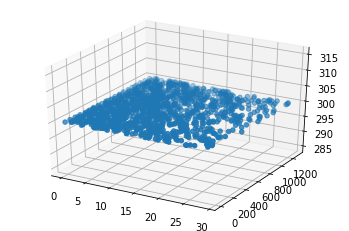

After steep gradient suppression...


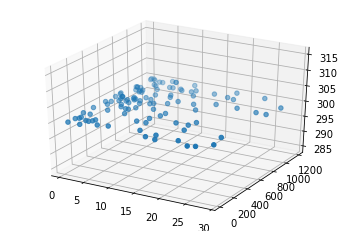

In [219]:
lidar_data = generate_baseline_LIDAR_points(300, 1280, simple_lidar_grid_function, random_lidar_radius_function)
plot_ppcs(lidar_data.ppcs)
print("After steep gradient suppression...")
ppcs = suppress_steep_gradients(lidar_data.ppcs, 0.3)
plot_ppcs(ppcs)

## Bounding Box Mapping

In [220]:
def calculate_depth_for_bboxes(bboxes, ppcs):
    # Git y range if bounding box
    for bbox in bboxes:
        # Fit bboxes to projected polar coordinates
        fitting_ppcs = []
        for ppc in ppcs:
            if ppc.fits_in_bbox(bbox):
                fitting_ppcs.append(ppc)
        # Calculate weighted average
        distance_sum = 0
        for fitting_ppc in fitting_ppcs:
            distance_sum = distance_sum + fitting_ppc.calculate_distance()
        if len(fitting_ppcs) > 0:
            average = distance_sum / len(fitting_ppcs)
            print("Average distance to ", bbox.as_string(), ":", average)

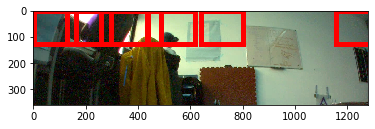

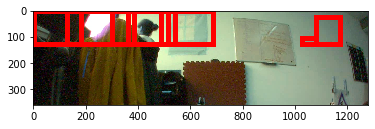

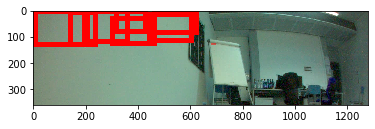

ValueError: n_samples=1 should be >= n_clusters=2

In [221]:
bboxes = calculate_bounding_boxes_for_image_sequence(image_sequence, 2000, slice_ratio=SLICE_RATIO, step_size=10)
calculate_depth_for_bboxes(bboxes, ppcs)